In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.densenet import DenseNet201

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

Using TensorFlow backend.


In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, img_size = 299,
                                               mean_proc='VGG16_ImageNet', test_size=0.1)

# Xception Fine Tuning

In [3]:
model_name = 'Xception-Fine-Tune'

img_rows, img_cols, img_channel = 299, 299, 3
base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 10
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    verbose=2)

Epoch 1/100
 - 123s - loss: 1.9527 - acc: 0.3851 - val_loss: 0.8802 - val_acc: 0.8094

Epoch 00001: val_loss improved from inf to 0.88019, saving model to ./saved_models/Xception-Fine-Tune.h5
Epoch 2/100
 - 81s - loss: 0.9241 - acc: 0.7243 - val_loss: 0.4109 - val_acc: 0.9130

Epoch 00002: val_loss improved from 0.88019 to 0.41093, saving model to ./saved_models/Xception-Fine-Tune.h5
Epoch 3/100
 - 81s - loss: 0.5917 - acc: 0.8299 - val_loss: 0.2836 - val_acc: 0.9298

Epoch 00003: val_loss improved from 0.41093 to 0.28361, saving model to ./saved_models/Xception-Fine-Tune.h5
Epoch 4/100
 - 81s - loss: 0.4528 - acc: 0.8638 - val_loss: 0.2058 - val_acc: 0.9599

Epoch 00004: val_loss improved from 0.28361 to 0.20576, saving model to ./saved_models/Xception-Fine-Tune.h5
Epoch 5/100
 - 82s - loss: 0.3607 - acc: 0.9000 - val_loss: 0.1902 - val_acc: 0.9632

Epoch 00005: val_loss improved from 0.20576 to 0.19016, saving model to ./saved_models/Xception-Fine-Tune.h5
Epoch 6/100
 - 81s - loss: 0

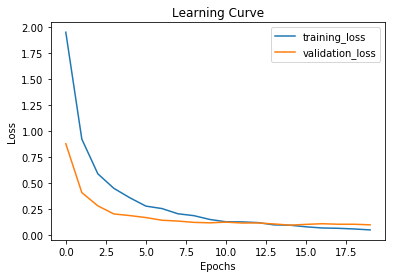

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

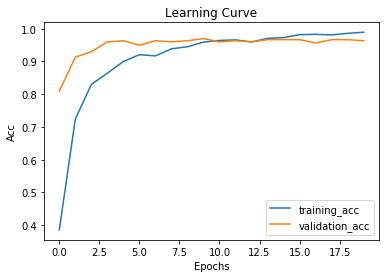

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [7]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet', img_size=299)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 10s 34ms/step
Validation loss: 0.09847121603512844
Validation accuracy: 0.9665551849432215
